In [1]:
from abc import ABC, abstractmethod
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
### MLP
class Multi_Layer_Perceptron(nn.Sequential):
    def __init__(self, input_dim, intern_dim, output_dim, depth = 2, isBiased = False):
        
        dict = OrderedDict([("input",nn.Linear(input_dim,intern_dim, bias=isBiased))])
        for i in range(depth):
            dict.update({str(i) : nn.Linear(intern_dim,intern_dim,bias=isBiased)})
        dict.update({"output" : nn.Linear(intern_dim,output_dim,bias=isBiased)})

        super().__init__(dict)

        self.reset_init_weights_biases(0) # so that we do not use a default initialization

    def reset_init_weights_biases(self, norm = -1):
        for layer in self.children():
            if norm == -1:
                stdv = 1. / math.sqrt(layer.weight.size(1))
            else :
                stdv = norm
            layer.weight.data.fill_(stdv)
            if layer.bias is not None:
                layer.bias.data.fill_(stdv)

In [3]:
class Agent(ABC):

    @abstractmethod
    def observe(self, state, action, next_state, reward):
        pass

    @abstractmethod
    def select_action(self, state):
        pass
    
    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def train(self, episodes, debug_mode=False):
        pass

    def __init__(self, id, env):
        self.id = id
        self.env = env
                

In [4]:
class RandomAgent(Agent):
    def observe(self, state, action, next_state, reward):
        pass
        
    def select_action(self, state):
        return random.randint(0,1)
        
        
    def update(self):
        pass

    def train(self, episodes, debug_mode=False):
        episodesHistory = np.zeros((episodes))
        
        for i in range(episodes):
            if(debug_mode) : print("Episode: "+str(i+1)+" starts")
            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            done = False
            episode_reward = 0
            
            while not done:
                                        
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                self.observe(state,action,next_state,reward)
                self.update()

                episode_reward += reward
                state = next_state
                done = terminated or truncated

            episodesHistory[i] = episode_reward
            if(debug_mode) : print("Episode "+str(i+1)+ " , Reward: "+str(episode_reward))
        print(episodesHistory[:])

In [52]:
class DQNAgent(Agent):

    def __init__(self, id, epsilonMax, epsilonMin = 0.05, LossFct = torch.nn.MSELoss(reduction='mean'),  Q = Multi_Layer_Perceptron(input_dim = 3,intern_dim = 64, output_dim = 1, depth = 2, isBiased = False), env = gym.make('MountainCar-v0'), arrayNewPosReward = None, arrayNewVelReward = None, contReward = False, gamma = 0.99, replay_buffer_SIZE = 10000, batch_size = 64, observation_SIZE = 6, optimizer = torch.optim.AdamW):
        Agent.__init__(self,id,env)
        self.Q = Q
        self.QTarget = Q
        self.gamma = gamma
        self.epsilon = epsilonMax
        self.epsilonMax = epsilonMax
        self.epsilonMin = epsilonMin
        self.replay_buffer = np.zeros((replay_buffer_SIZE,observation_SIZE))
        self.batch_size = batch_size
        self.optimizer = optimizer(self.Q.parameters())
        self.replay_buffer_SIZE = replay_buffer_SIZE
        self.observation_SIZE = observation_SIZE
        self.arrayNewPosReward = arrayNewPosReward
        self.arrayNewVelReward = arrayNewVelReward
        self.contReward = contReward
        self.LossFct = LossFct
        
    def observe(self, state, action, next_state, reward):
        state = np.array(state)
        action = np.array([action])
        next_state = np.array(next_state)
        reward = np.array([reward])

        concatenatation = np.concatenate((state, action, next_state, reward))
        return concatenatation
        
    def select_action(self, state):
        P = random.uniform(0,1)
        a=0
        if P <= 1-self.epsilon :
            A=np.zeros(3)
            o = []
            ArgQmax = 0
            for k in range(3):
                A[k] = self.Q(torch.from_numpy(np.concatenate((np.array(state), np.array([k])))).to(torch.float32))
            a = np.argmax(A)
            for k in range(3):
                if A[k] == A[a]:
                    o.append(k)
            a =random.choice(o)
                
        else:
            a = random.randint(0,2)
        return a
        
        
    def update(self,j):
        #print(min(j,self.replay_buffer.shape[0]))
        batchIndex = np.random.choice(min(j,self.replay_buffer.shape[0]), self.batch_size)
        batch = self.replay_buffer[batchIndex,:]
        target = torch.zeros((self.batch_size))
        input = torch.zeros((self.batch_size))

        A0= np.copy(batch[:,3:6])
        A0[:,2] = 0.
        A1= np.copy(batch[:,3:6])
        A1[:,2] = 1.
        A2= np.copy(batch[:,3:6])
        A2[:,2] = 2.
        A = np.concatenate((A0,A1,A2), axis=0)
        #print(A)
        A = torch.from_numpy(A).to(torch.float32)
        Qtarget = self.QTarget(A)
        QMax = np.array([max(float(Qtarget[i]),float(Qtarget[i+self.batch_size]),float(Qtarget[i+2*self.batch_size])) for i in range(self.batch_size)])
        target = torch.from_numpy(batch[:,5] + self.gamma*QMax).to(torch.float32)
                
        input = self.Q(torch.from_numpy(batch[:,:3]).to(torch.float32))
        loss = self.LossFct(input, target)
        for param in self.Q.parameters():
            param.grad = None
            
        loss.backward()

        grad = 0
        for layer in self.Q.children():
            grad += layer.weight.grad.mean()
        
        self.optimizer.step()
        #print(time.time() - start_time)
        return loss.item(), abs(grad)

    def customReward(self, state, action, currentReward, next_state, uniqueReward, excludePassivity):
        reward = -1

        if excludePassivity and action == 1:
            reward -= 2

        if self.contReward:
            reward = (abs(next_state[0] + 0.5)**2)/200
        
        if self.arrayNewPosReward.all() != None:
            for k in range(self.arrayNewPosReward.shape[0]):
                #print(i)
                i = self.arrayNewPosReward[k,0]
                if (i <= next_state[0] and i +0.5 >=0) or (i >= next_state[0] and i +0.5 <=0):
                    if self.arrayNewPosReward[k,2] == 0:
                        if self.arrayNewPosReward[k,1] > reward:
                            reward = self.arrayNewPosReward[k,1]
                            if uniqueReward: self.arrayNewPosReward[k,2] = 1
                        
        if self.arrayNewVelReward.all() != None:
            for k in range(self.arrayNewVelReward.shape[0]):
                i = self.arrayNewVelReward[k,0]
                if (i < state[1] and i>0 and action == 2) or (i > state[1] and i<0 and action == 0):
                    reward += self.arrayNewVelReward[k,1]
                    #print(state[1])
                    #print(action)
                    
        return reward

    def play(self):
        self.epsilon = 0
        newSeed = random.randint(0,100000)
        state,_ = self.env.reset(seed = newSeed)
        done = False
                    
        while done == False:
                                        
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
        self.env.close()
    
    def train(self, episodes,lossLim = 0, limitStep = 200, refreshTarget = 200, refreshQ = 1, buffer_fill = True, epsilonDecreasing =100, debug_mode=False, recap_mode=False, reset_init = False, epsilon_decrease = True, uniqueReward = False, excludePassivity = True):
        start_time = time.time()
        episodesHistory = np.zeros((episodes))
        rewardHistory = np.zeros((episodes*limitStep))
        lossHistory = np.zeros((int(episodes*limitStep/refreshQ)))
        gradHistory = np.zeros((int(episodes*limitStep/refreshQ)))
        cumulativeHistory = np.zeros((episodes))
        self.QTarget = self.Q
        if reset_init != False: self.Q.reset_init_weights_biases(reset_init)
        j=0
        self.replay_buffer = np.zeros((self.replay_buffer_SIZE, self.observation_SIZE))
        k=0
        for e in range (episodes):
            l=0
            terminated = False
            if debug_mode: print("Episode: "+str(e+1)+" starts")
                
            if epsilon_decrease: 
                if self.epsilon > self.epsilonMin:
                    self.epsilon = self.epsilonMax*math.exp(-e/epsilonDecreasing)
            else:
                self.epsilon = self.epsilonMax
                
            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            done = False
            episode_reward = 0
            if self.arrayNewPosReward.all() != None:
                for i in range(self.arrayNewPosReward.shape[0]):
                    self.arrayNewPosReward[i,2] = 0

            s=1
            while done == False:
                j+=1               
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                if s >= limitStep:
                    truncated = True
                else:
                    truncated = False

                s+=1
                reward = self.customReward(state, action,reward, next_state, uniqueReward, excludePassivity)
                if debug_mode: print("Action "+str(k)+" selected: "+str(action)+" Reward: "+ str(reward))
                observe = self.observe(state,action,next_state,reward)
                
                if k < self.replay_buffer_SIZE: self.replay_buffer[k] = observe
                elif buffer_fill: k=-1
                k+=1
                
                episode_reward += reward
                state = next_state
                done = terminated or truncated
                if j%refreshQ == 0:
                    l,g = self.update(j)
                    lossHistory[int(j/refreshQ)-1] = l
                    gradHistory[int(j/refreshQ)-1] = g
                if j%refreshTarget == 0:
                    print("Loss: "+str(l))
                    self.QTarget = self.Q
                    #for param in self.Q.parameters():
                        #print(param.data)

                rewardHistory[j-1] = reward
                
            if terminated:
                if e > 0:
                    cumulativeHistory[e] = cumulativeHistory[e-1] +1
                else:
                    cumulativeHistory[e] = 1
            else:
                if e > 0:
                    cumulativeHistory[e] = cumulativeHistory[e-1]
                else:
                    cumulativeHistory[e] = 0
                                    
            if debug_mode or recap_mode: print("Episode "+str(e+1)+ " , Reward: "+str(episode_reward)+" Epsilon: "+str(self.epsilon))
            episodesHistory[e] = episode_reward
            
            if l <= lossLim:
                print("Loss reaches limit")
                break
                
        print(time.time() - start_time)
        return episodesHistory, rewardHistory, lossHistory, gradHistory, cumulativeHistory

In [54]:
u=0.01
episodes = 1000
lossLimTrain = -1
batch_size = 64
refreshQ = 1
refreshTarget = 10000
reset_init = 0.1
replay_buffer_SIZE = 10000
epsilonDecreasing = 200

NewPosReward=np.array([(-1.1,u*7,0),(-1,u*6,0),(-0.9,u*5,0),(-0.8,u*4,0),(-0.7,u*3,0),(-0.6,u*2,0),(-0.4,u*2,0),(-0.3,u*3,0),(-0.2,u*4,0),(-0.1,u*5,0),(0,u*6,0),(0.1,u*7,0),(0.2,u*8,0),(0.3,u*9,0),(0.4,u*10,0),(0.5,20*u,0)])
NewVelReward=np.array([(0.001,1),(-0.001,1)])
No = np.array([None])
DQN = DQNAgent("id0",epsilonMax = 1, epsilonMin = 0.05, batch_size = batch_size, contReward = False, arrayNewPosReward = NewPosReward, arrayNewVelReward = No, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, rewardHistory, lossHistory, gradHistory, cumulativeHistory= DQN.train(episodes,lossLim=lossLimTrain,limitStep = 200,buffer_fill = True, refreshTarget = refreshTarget, refreshQ = refreshQ, debug_mode = False, recap_mode=True, reset_init = reset_init, uniqueReward = False, excludePassivity = False, epsilonDecreasing =epsilonDecreasing)


Episode 1 , Reward: -185.71999999999997 Epsilon: 1.0
Episode 2 , Reward: -190.8199999999999 Epsilon: 0.9950124791926823
Episode 3 , Reward: -173.48000000000008 Epsilon: 0.9900498337491681
Episode 4 , Reward: -177.55999999999977 Epsilon: 0.9851119396030626
Episode 5 , Reward: -195.91999999999996 Epsilon: 0.9801986733067553
Episode 6 , Reward: -198.98 Epsilon: 0.9753099120283326
Episode 7 , Reward: -98.60000000000008 Epsilon: 0.9704455335485082
Episode 8 , Reward: -98.00000000000023 Epsilon: 0.9656054162575665
Episode 9 , Reward: -200 Epsilon: 0.9607894391523232
Episode 10 , Reward: -152.05999999999983 Epsilon: 0.9559974818331
Episode 11 , Reward: -200 Epsilon: 0.951229424500714
Episode 12 , Reward: -153.07999999999984 Epsilon: 0.9464851479534838
Episode 13 , Reward: -200 Epsilon: 0.9417645335842487
Episode 14 , Reward: -114.15000000000025 Epsilon: 0.9370674633774034
Episode 15 , Reward: -99.55000000000007 Epsilon: 0.9323938199059483
Episode 16 , Reward: -188.78000000000003 Epsilon: 0.92

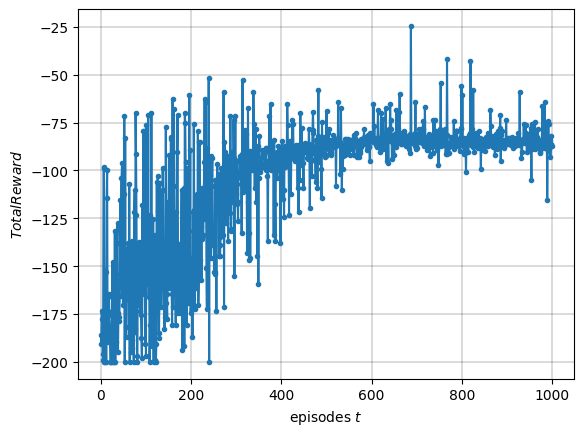

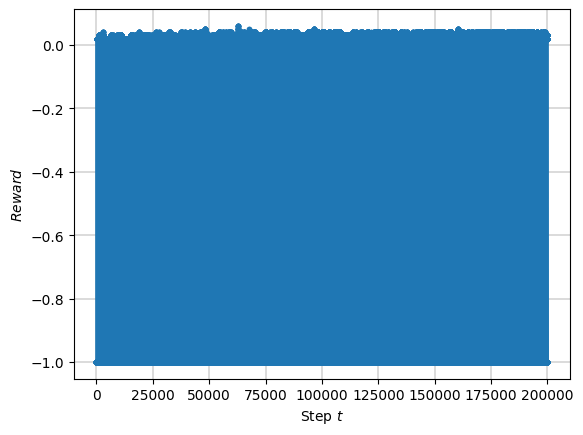

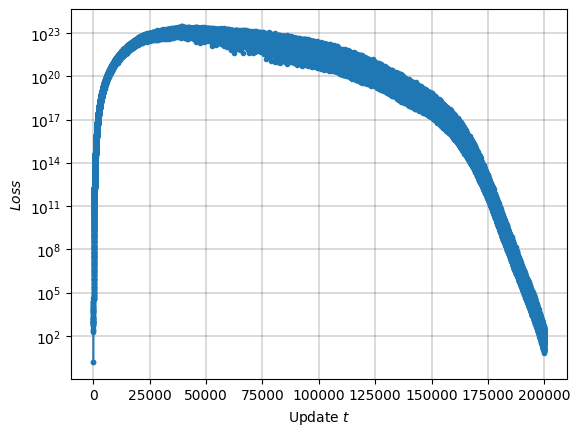

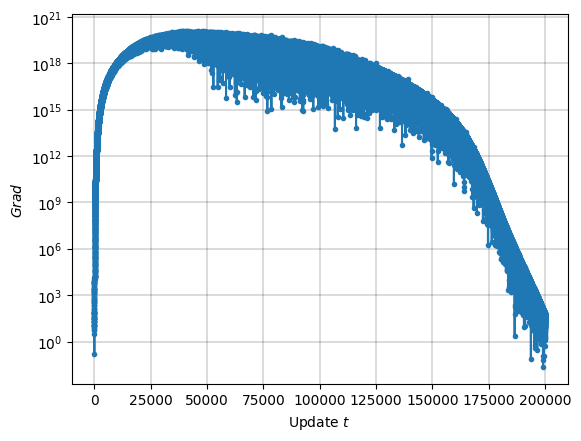

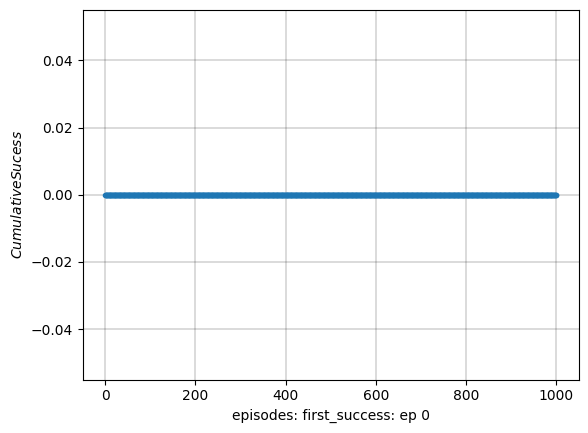

In [55]:
fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(episodesHistory.shape[0]), episodesHistory, marker='.')
ax1.set_xlabel(r'episodes $t$')
ax1.set_ylabel(r'$Total Reward$')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/TotalReward_epochs{str(episodes)}_u{str(u)}_bS{str(batch_size)}_rQ{str(refreshQ)}_rT{str(refreshTarget)}_rI{str(reset_init)}_rB{str(replay_buffer_SIZE)}_ep{str(epsilonDecreasing)}.png', format='png')

fig2,ax2 = plt.subplots(1,1)
ax2.plot(range(rewardHistory.shape[0]), rewardHistory, marker='.')
ax2.set_xlabel(r'Step $t$')
ax2.set_ylabel(r'$Reward$')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/Reward_epochs{episodes}_u{u}_bS{batch_size}_rQ{refreshQ}_rT{refreshTarget}_rI{reset_init}_rB{replay_buffer_SIZE}_ep{epsilonDecreasing}.png', format='png')


fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker='.')
ax3.set_xlabel(r'Update $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
#plt.ylim(top=0.15)
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/Loss_epochs{episodes}_u{u}_bS{batch_size}_rQ{refreshQ}_rT{refreshTarget}_rI{reset_init}_rB{replay_buffer_SIZE}_ep{epsilonDecreasing}.png', format='png')

fig4,ax4 = plt.subplots(1,1)
ax4.plot(range(gradHistory.shape[0]), gradHistory, marker='.')
ax4.set_xlabel(r'Update $t$')
ax4.set_ylabel(r'$Grad$')
ax4.set_xscale('linear')
ax4.set_yscale('log')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/Grad_epochs{episodes}_u{u}_bS{batch_size}_rQ{refreshQ}_rT{refreshTarget}_rI{reset_init}_rB{replay_buffer_SIZE}_ep{epsilonDecreasing}.png', format='png')


s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0] - s), cumulativeHistory[s:], marker='.')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucess_epochs{episodes}_u{u}_bS{batch_size}_rQ{refreshQ}_rT{refreshTarget}_rI{reset_init}_rB{replay_buffer_SIZE}_ep{epsilonDecreasing}.png', format='png')

In [8]:
DQN.env = gym.make('MountainCar-v0', render_mode='human')
DQN.play()

In [9]:
step = 0.5
MatVel = np.arange(-1*100,1*100,step*100, dtype = int)
step2 = 0.01
MatPos = np.arange(-1.2*100,(0.5+step2)*100,step2*100, dtype = int)
print(MatVel.shape[0])
print(MatPos.shape[0])

MatState = np.array((MatVel.shape[0]*MatPos.shape[0]))
MatState[:171]
MatState[171:2*171]
vel = 0.11
indexV = 0
for i in range(MatVel.shape[0]):
    if MatVel[i] >= vel*100:
        indexV = i
        break
print(vel/100)

indexState = iV*MatPos.shape[0] + iP

iV = iS//MatPos.shape[0]
iP = iS%MatPos.shape[0]

4
171


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
    def update(self,j):
        #print(min(j,self.replay_buffer.shape[0]))
        batch = np.random.choice(min(j,self.replay_buffer.shape[0]), self.batch_size)
        target = torch.zeros((self.batch_size))
        input = torch.zeros((self.batch_size))
        start_time = time.time()
        for i in range(self.batch_size):
            if self.replay_buffer[batch[i],3] <0.5:
                A0 = torch.from_numpy(np.concatenate((self.replay_buffer[batch[i],3:5], np.array([0])))).to(torch.float32)
                A1 = torch.from_numpy(np.concatenate((self.replay_buffer[batch[i],3:5], np.array([1])))).to(torch.float32)
                A2 = torch.from_numpy(np.concatenate((self.replay_buffer[batch[i],3:5], np.array([2])))).to(torch.float32)
                target[i] = self.replay_buffer[batch[i],5] + self.gamma*max(self.QTarget(A0),self.QTarget(A1),self.QTarget(A2))
            else:
                target[i] = self.replay_buffer[batch[i],5]
                
            input[i] = self.Q(torch.from_numpy(self.replay_buffer[batch[i],:3]).to(torch.float32))
        print(time.time() - start_time)
        loss = self.LossFct(input, target)
        for param in self.Q.parameters():
            param.grad = None
            
        loss.backward()

        grad = 0
        for layer in self.Q.children():
            grad += layer.weight.grad.mean()
        
        self.optimizer.step()
        return loss.item(), abs(grad)